## Загрузка и подготовка данных

В задании требуется применить SVM с линейным ядром к нелинейно распределенным данным.
Понятно, что это не будет работать хорошо, поэтому сначала необходимо предобработать данные таким образом,
чтобы к ним можно было применять SVM с линейным ядром.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('custom_dataset.csv')

In [3]:
data.head()

,Unnamed: 0,feature_1,feature_2,target
0,0,0.027957,0.856195,0
1,1,-0.452472,0.880457,0
2,2,0.006996,0.815738,0
3,3,-0.721376,0.992746,0
4,4,-0.104573,0.831477,0


In [4]:
X = data[["feature_1", "feature_2"]].to_numpy()
y = data["target"].to_numpy(dtype=np.int32)

Датасет представлен синими и зелеными точками. Красной линией обозначена кривая преобразования,
которое будет применено к данным в дальнейшем.

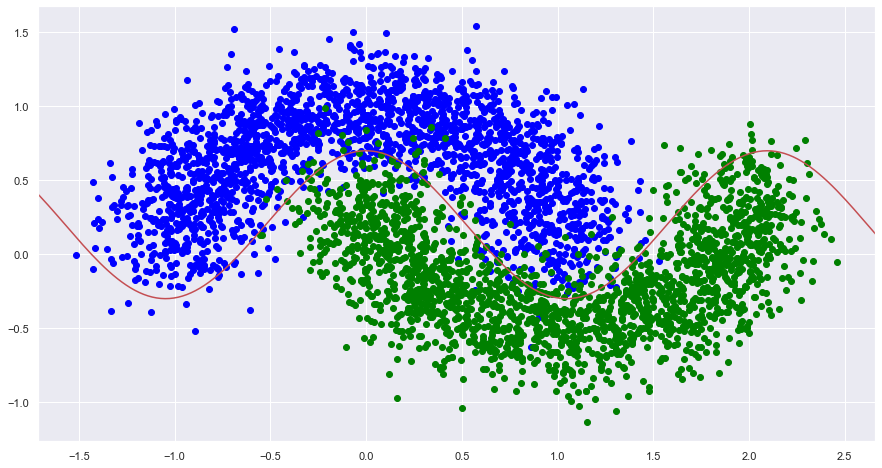

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
colors = {0:'blue', 1:'green'}

for key, value in colors.items():   
    ax.scatter(X[y==key, 0], X[y==key, 1], c=value, label=key)

plt.axis('tight')

# преобразование
x_tr = np.linspace(-1.75, 2.75, 200)
plt.plot(x_tr, 0.5*np.cos(3*x_tr) + 0.2, color='r')

plt.show()

In [6]:
X_tr = np.zeros_like(X)
X_tr[:, 0] = 0.5*np.cos(3*X[:, 0]) + 0.2
X_tr[:, 1] = X[:, 1]

Данные после преобразования. Теперь их проще разделить линейно.

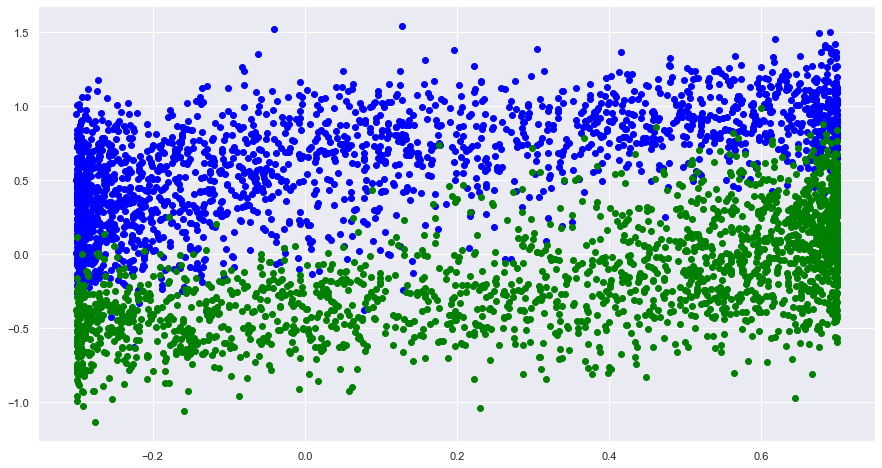

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
colors = {0:'blue', 1:'green'}

for key, value in colors.items():   
    ax.scatter(X_tr[y==key, 0], X_tr[y==key, 1], c=value, label=key)

plt.axis('tight')

plt.show()

Делим данные на тест и трейн части.

In [8]:
from sklearn.model_selection import train_test_split

# данные до предобработки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# обработанные данные
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y, test_size=0.2, random_state=42)

## Данные без предобработки

Сначала проверим работу алгоритмов на сырых данных.

### Sklearn SVM

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
SVM_model = SVC(kernel="linear")
SVM_model.fit(X_train, y_train)
print("Train accuracy:", SVM_model.score(X_train, y_train))

SVM_preds = SVM_model.predict(X_test)

print("\nConfusion matrix on test:\n", confusion_matrix(y_test, SVM_preds), sep="")
print(
    "\nMetrics on test:\n",
    classification_report(
        y_test,
        SVM_preds,
        target_names=["blue", "green"]
    ),
    sep=""
)

Train accuracy: 0.8608058608058609

Confusion matrix on test:
[[358  54]
 [ 49 359]]

Metrics on test:
              precision    recall  f1-score   support

        blue       0.88      0.87      0.87       412
       green       0.87      0.88      0.87       408

    accuracy                           0.87       820
   macro avg       0.87      0.87      0.87       820
weighted avg       0.87      0.87      0.87       820



Таким образом, SVM с линейным ядром позволяет на сырых данных достичь качества порядка 0.87

Отрисуем разделяющую полосу.

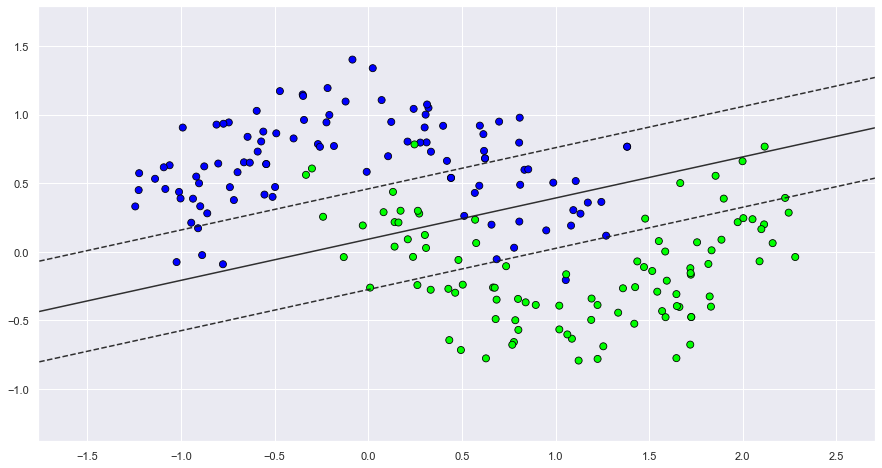

In [11]:
x_min, x_max = X_train[:, 0].min() - 0.25, X_train[:, 0].max() + 0.25
y_min, y_max = X_train[:, 1].min() - 0.25, X_train[:, 1].max() + 0.25

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

P = SVM_model.decision_function(xy).reshape(xx.shape)

# plot decision boundary and margins
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.contour(xx, yy, P, colors='k',
           levels=[-1, 0, 1], alpha=0.9,
           linestyles=['--', '-', '--'])

random_indxs = np.random.randint(0, X_train.shape[0], 200)
plt.scatter(X_train[random_indxs, 0], X_train[random_indxs, 1], 
            c=y_train[random_indxs], s=50, cmap='brg',
            edgecolors='black', linewidth=0.8)

plt.axis('tight')
plt.show()

Как видно, решение далеко от идеала.

Посчитаем ширину разделяющей полосы.

In [12]:
xx_1 = np.where(np.isclose(P, 1, rtol=1e-1, atol=1e-1), xx, 0)
yy_1 = np.where(np.isclose(P, 1, rtol=1e-1, atol=1e-1), yy, 0)
xy_1 = np.vstack([xx_1.ravel(), yy_1.ravel()]).T

xx_1_neg = np.where(np.isclose(P, -1, rtol=1e-1, atol=1e-1), xx, 0)
yy_1_neg = np.where(np.isclose(P, -1, rtol=1e-1, atol=1e-1), yy, 0)
xy_1_neg = np.vstack([xx_1_neg.ravel(), yy_1_neg.ravel()]).T

In [13]:
data_1 = []
for point in xy_1:
    if point[0] != .0 and point[1] != .0:
        data_1.append(point)
        
data_1_neg = []
for point in xy_1_neg:
    if point[0] != .0 and point[1] != .0:
        data_1_neg.append(point)

In [14]:
data_1 = np.array(data_1)
data_1_neg = np.array(data_1_neg)

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
line_1 = LinearRegression()
line_1_neg = LinearRegression()

line_1.fit(data_1[:, 0].reshape(-1, 1), data_1[:, 1])
line_1_neg.fit(data_1_neg[:, 0].reshape(-1, 1), data_1_neg[:, 1])

print("Line = 1 slope:", line_1.coef_[0])
print("Line = -1 slope:", line_1_neg.coef_[0])

print("Line = 1 intersection:", line_1.intercept_)
print("Line = -1 intersection:", line_1_neg.intercept_)

Line = 1 slope: 0.29999402292212735
Line = -1 slope: 0.29999994600597096
Line = 1 intersection: -0.2743832625566423
Line = -1 intersection: 0.4596092286444793


Slope у обеих линий практически одинаковый, из чего следует, что они параллельны.
Для этого случая есть простая формула вычисления по коэффициентам прямых расстояния между ними.

In [17]:
svm_strip_width = np.abs(line_1.intercept_ - line_1_neg.intercept_)\
    / np.sqrt(1 + np.mean([line_1.coef_[0], line_1_neg.coef_[0]]))

print("Strip width =", svm_strip_width)

Strip width = 0.6437547471601298


### Sklearn kNN

Сравним SVM с kNN на необработанных данных.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
kNN_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
kNN_model.fit(X_train, y_train)
print("Train accuracy:", kNN_model.score(X_train, y_train))

kNN_preds = kNN_model.predict(X_test)

print("\nConfusion matrix on test:\n", confusion_matrix(y_test, kNN_preds), sep="")
print(
    "\nMetrics on test:\n",
    classification_report(
        y_test,
        kNN_preds,
        target_names=["blue", "green"]
    ),
    sep=""
)

Train accuracy: 1.0

Confusion matrix on test:
[[398  14]
 [ 20 388]]

Metrics on test:
              precision    recall  f1-score   support

        blue       0.95      0.97      0.96       412
       green       0.97      0.95      0.96       408

    accuracy                           0.96       820
   macro avg       0.96      0.96      0.96       820
weighted avg       0.96      0.96      0.96       820



Как видим, kNN в случае сырых данных работает лучше, чем SVM.

Визуализируем kNN.

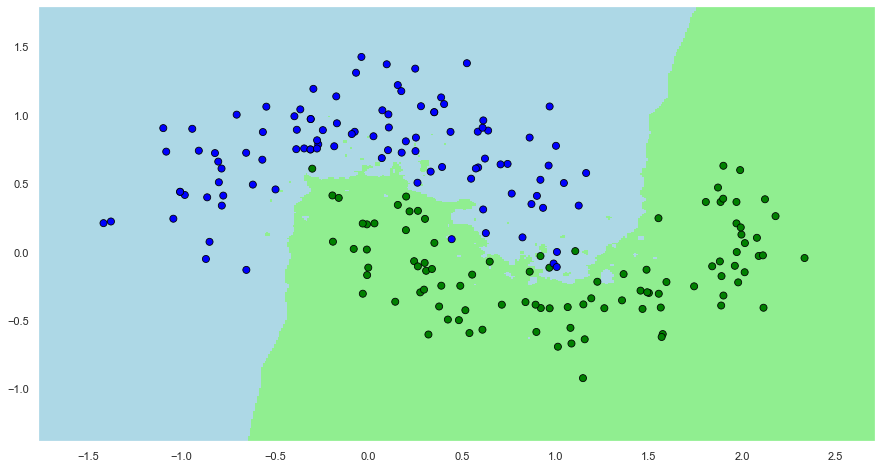

In [20]:
colors = ListedColormap(["blue", "green"])
light_colors = ListedColormap(["lightblue", "lightgreen"])

x_min, x_max = X_train[:, 0].min() - 0.25, X_train[:, 0].max() + 0.25
y_min, y_max = X_train[:, 1].min() - 0.25, X_train[:, 1].max() + 0.25

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
predicted = kNN_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

random_indxs = np.random.randint(0, X_train.shape[0], 200)

plt.rcParams['figure.figsize'] = (15, 8)
plt.pcolormesh(xx, yy, predicted, cmap=light_colors, shading="auto")
plt.scatter(X_train[random_indxs, 0], X_train[random_indxs, 1],
            c=y_train[random_indxs], s=50, cmap=colors,
            edgecolors='black', linewidth=0.8)

plt.show()

## Предобработанные данные

Теперь применим алгоритмы к трансформированным данным.

### Sklearn SVM

In [21]:
SVM_model = SVC(kernel="linear")
SVM_model.fit(X_tr_train, y_tr_train)
print("Train accuracy:", SVM_model.score(X_tr_train, y_tr_train))

SVM_preds = SVM_model.predict(X_tr_test)

print("\nConfusion matrix on test:\n", confusion_matrix(y_tr_test, SVM_preds), sep="")
print(
    "\nMetrics on test:\n",
    classification_report(
        y_tr_test,
        SVM_preds,
        target_names=["blue", "green"]
    ),
    sep=""
)

Train accuracy: 0.9554334554334555

Confusion matrix on test:
[[393  19]
 [ 25 383]]

Metrics on test:
              precision    recall  f1-score   support

        blue       0.94      0.95      0.95       412
       green       0.95      0.94      0.95       408

    accuracy                           0.95       820
   macro avg       0.95      0.95      0.95       820
weighted avg       0.95      0.95      0.95       820



Качество значительно улучшилось относительно SVM на сырых данных и теперь сравнимо с тем, что получается при использовании kNN на данных без предобработки.

Аналогично случаю необработанных данных, визуализируем разделяющую полосу и вычислим ее ширину.

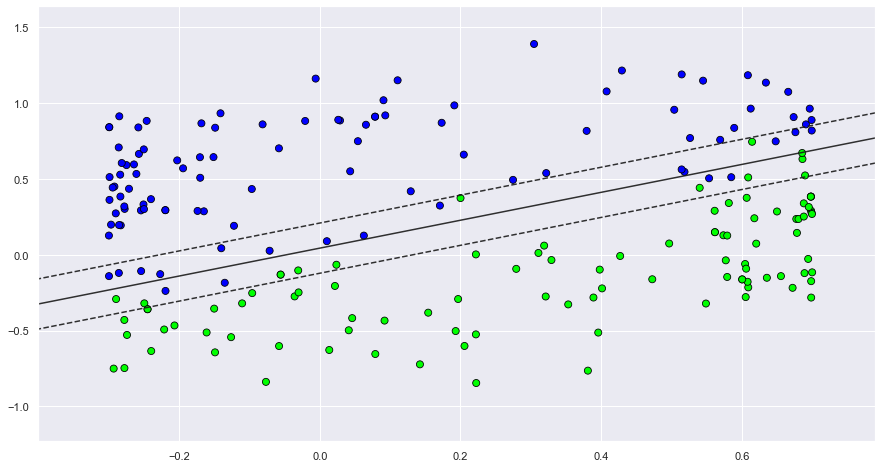

In [22]:
x_min, x_max = X_tr_train[:, 0].min() - 0.1, X_tr_train[:, 0].max() + 0.1
y_min, y_max = X_tr_train[:, 1].min() - 0.1, X_tr_train[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

P = SVM_model.decision_function(xy).reshape(xx.shape)

# plot decision boundary and margins
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.contour(xx, yy, P, colors='k',
           levels=[-1, 0, 1], alpha=0.9,
           linestyles=['--', '-', '--'])

random_indxs = np.random.randint(0, X_tr_train.shape[0], 200)
plt.scatter(X_tr_train[random_indxs, 0], X_tr_train[random_indxs, 1], 
            c=y_tr_train[random_indxs], s=50, cmap='brg',
            edgecolors='black', linewidth=0.8)

plt.axis('tight')
plt.show()

In [23]:
xx_1 = np.where(np.isclose(P, 1, rtol=1e-1, atol=1e-1), xx, 0)
yy_1 = np.where(np.isclose(P, 1, rtol=1e-1, atol=1e-1), yy, 0)
xy_1 = np.vstack([xx_1.ravel(), yy_1.ravel()]).T

xx_1_neg = np.where(np.isclose(P, -1, rtol=1e-1, atol=1e-1), xx, 0)
yy_1_neg = np.where(np.isclose(P, -1, rtol=1e-1, atol=1e-1), yy, 0)
xy_1_neg = np.vstack([xx_1_neg.ravel(), yy_1_neg.ravel()]).T

data_1 = []
for point in xy_1:
    if point[0] != .0 and point[1] != .0:
        data_1.append(point)
        
data_1_neg = []
for point in xy_1_neg:
    if point[0] != .0 and point[1] != .0:
        data_1_neg.append(point)
                
data_1 = np.array(data_1)
data_1_neg = np.array(data_1_neg)

line_1 = LinearRegression()
line_1_neg = LinearRegression()

line_1.fit(data_1[:, 0].reshape(-1, 1), data_1[:, 1])
line_1_neg.fit(data_1_neg[:, 0].reshape(-1, 1), data_1_neg[:, 1])

print("Line = 1 slope:", line_1.coef_[0])
print("Line = -1 slope:", line_1_neg.coef_[0])

print("Line = 1 intersection:", line_1.intercept_)
print("Line = -1 intersection:", line_1_neg.intercept_)

svm_strip_width = np.abs(line_1.intercept_ - line_1_neg.intercept_)\
    / np.sqrt(1 + np.mean([line_1.coef_[0], line_1_neg.coef_[0]]))

print("Strip width =", svm_strip_width)

Line = 1 slope: 0.9205354138749391
Line = -1 slope: 0.9208795053438159
Line = 1 intersection: -0.12178284290352179
Line = -1 intersection: 0.20943827419737507
Strip width = 0.23899422452734725


### Sklearn kNN

In [24]:
kNN_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
kNN_model.fit(X_tr_train, y_tr_train)
print("Train accuracy:", kNN_model.score(X_tr_train, y_tr_train))

kNN_preds = kNN_model.predict(X_tr_test)

print("\nConfusion matrix on test:\n", confusion_matrix(y_tr_test, kNN_preds), sep="")
print(
    "\nMetrics on test:\n",
    classification_report(
        y_tr_test,
        kNN_preds,
        target_names=["blue", "green"]
    ),
    sep=""
)

Train accuracy: 1.0

Confusion matrix on test:
[[387  25]
 [ 26 382]]

Metrics on test:
              precision    recall  f1-score   support

        blue       0.94      0.94      0.94       412
       green       0.94      0.94      0.94       408

    accuracy                           0.94       820
   macro avg       0.94      0.94      0.94       820
weighted avg       0.94      0.94      0.94       820



Результаты практически не отличаются от того, что получается с помощью SVM на предобработанном датасете и kNN на сырых данных.

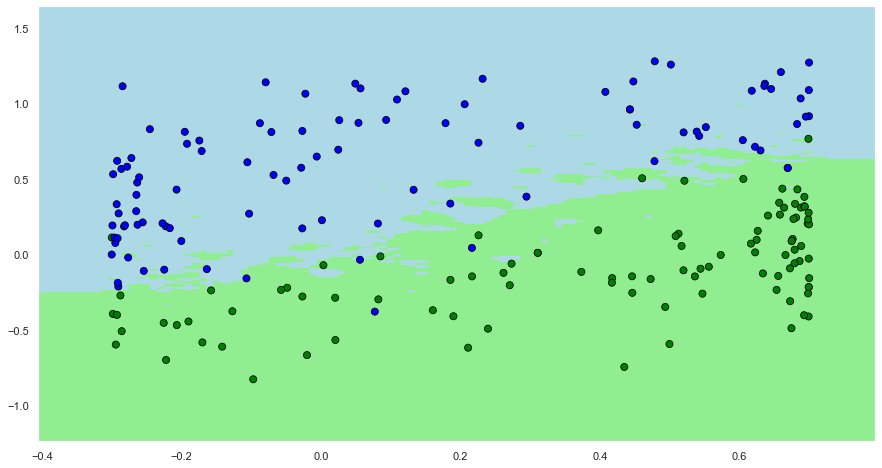

In [25]:
colors = ListedColormap(["blue", "green"])
light_colors = ListedColormap(["lightblue", "lightgreen"])

x_min, x_max = X_tr_train[:, 0].min() - 0.1, X_tr_train[:, 0].max() + 0.1
y_min, y_max = X_tr_train[:, 1].min() - 0.1, X_tr_train[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
predicted = kNN_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

random_indxs = np.random.randint(0, X_tr_train.shape[0], 200)

plt.rcParams['figure.figsize'] = (15, 8)
plt.pcolormesh(xx, yy, predicted, cmap=light_colors, shading="auto")
plt.scatter(X_tr_train[random_indxs, 0], X_tr_train[random_indxs, 1],
            c=y_tr_train[random_indxs], s=50, cmap=colors,
            edgecolors='black', linewidth=0.8)

plt.show()